Version 11 of the notebook in the link : 
https://www.kaggle.com/code/mahdyr/dcase2025-task1-dataset-melspecs-notebook?scriptVersionId=243547284

In [ ]:
import numpy as np
import os
import csv
import torch
import torchaudio
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
params = {
    'dataset_dir': "audio",
    'train_csv_file': "/kaggle/input/dcase-2025-task1/dataset/train.csv",
    'train_files_base_path': "/kaggle/input/dcase-2025-task1/dataset/train/",
    'test_csv_file': "/kaggle/input/dcase-2025-task1/dataset/test.csv",
    'test_files_base_path': "/kaggle/input/dcase-2025-task1/dataset/test/",
    'original_fs': 44100,
    'target_fs': 32000,
    'fft_size': 4096,
    'hop_length': 502,
    'nb_mels': 256,
}

In [3]:
# Data Generator class
class DataGenerator(Dataset):
    def __init__(self, params, mode='train'):  # mode = 'train' or 'test'
        self.params = params
        self.dataset_dir = params['dataset_dir']
        self.mode = mode
        if self.mode == 'train':
            self.csv_file = params['train_csv_file']
            self.base_path = params['train_files_base_path']
        else:
            self.csv_file = params['test_csv_file']
            self.base_path = params['test_files_base_path']

        self.filenames, self.labels, self.devices = self.read_csv_file()

        # Transforms
        self.resampler = torchaudio.transforms.Resample(orig_freq=params['original_fs'], new_freq=params['target_fs'])
        self.mel_spec_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.params['target_fs'],
            n_fft=self.params['fft_size'],
            hop_length=self.params['hop_length'],
            n_mels=self.params['nb_mels'],
            power=2.0
        )
        self.db_transform = torchaudio.transforms.AmplitudeToDB()

    def __getitem__(self, item):
        audio_file = self.filenames[item]
        label = self.labels[item]
        device = self.devices[item]
        # Load audio
        waveform, sr = torchaudio.load(audio_file)
        waveform = torch.mean(waveform, dim=0, keepdim=True)  # Mono
        waveform = self.resampler(waveform)
        # Compute log mel-spectrogram
        mel_spec = self.mel_spec_transform(waveform)
        log_mel_spec = torchaudio.functional.amplitude_to_DB(mel_spec, multiplier=10.0, amin=1e-10, db_multiplier=0.0)
        return log_mel_spec, device, label

    def __len__(self):
        return len(self.filenames)

    def read_csv_file(self):
        audio_filenames = []
        labels = []
        cities = []
        devices = []
        with open(self.csv_file, 'r') as file:
            reader = csv.reader(file, delimiter='\t')
            next(reader)
            for row in reader:
                audio_filename, label, dev = row[0].split(',')
                city = audio_filename.split('-')[1]
                cities.append(city)
                devices.append(dev)
                audio_filenames.append(self.base_path + audio_filename)
                labels.append(label)
        return audio_filenames, labels, devices

In [4]:
train_dataset = DataGenerator(params=params, mode='train')
test_dataset = DataGenerator(params=params, mode='test')

# Creating all the dataset
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=512, num_workers=0, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=512, num_workers=0, shuffle=False
)

# # For test on CPU
# train_loader = torch.utils.data.DataLoader(
#     Subset(train_dataset, range(16)), batch_size=4, num_workers=0, shuffle=False
# )
# test_loader = torch.utils.data.DataLoader(
#     Subset(test_dataset, range(16)), batch_size=4, num_workers=0, shuffle=False
# )

Precomputing and saving mel-spectrograms to /kaggle/working/dataset/train.npz ...
Batch 0/69 finished
Batch 1/69 finished
Batch 2/69 finished
Batch 3/69 finished
Batch 4/69 finished
Batch 5/69 finished
Batch 6/69 finished
Batch 7/69 finished
Batch 8/69 finished
Batch 9/69 finished
Batch 10/69 finished
Batch 11/69 finished
Batch 12/69 finished
Batch 13/69 finished
Batch 14/69 finished
Batch 15/69 finished
Batch 16/69 finished
Batch 17/69 finished
Batch 18/69 finished
Batch 19/69 finished
Batch 20/69 finished
Batch 21/69 finished
Batch 22/69 finished
Batch 23/69 finished
Batch 24/69 finished
Batch 25/69 finished
Batch 26/69 finished
Batch 27/69 finished
Batch 28/69 finished
Batch 29/69 finished
Batch 30/69 finished
Batch 31/69 finished
Batch 32/69 finished
Batch 33/69 finished
Batch 34/69 finished
Batch 35/69 finished
Batch 36/69 finished
Batch 37/69 finished
Batch 38/69 finished
Batch 39/69 finished
Batch 40/69 finished
Batch 41/69 finished
Batch 42/69 finished
Batch 43/69 finished
Batc

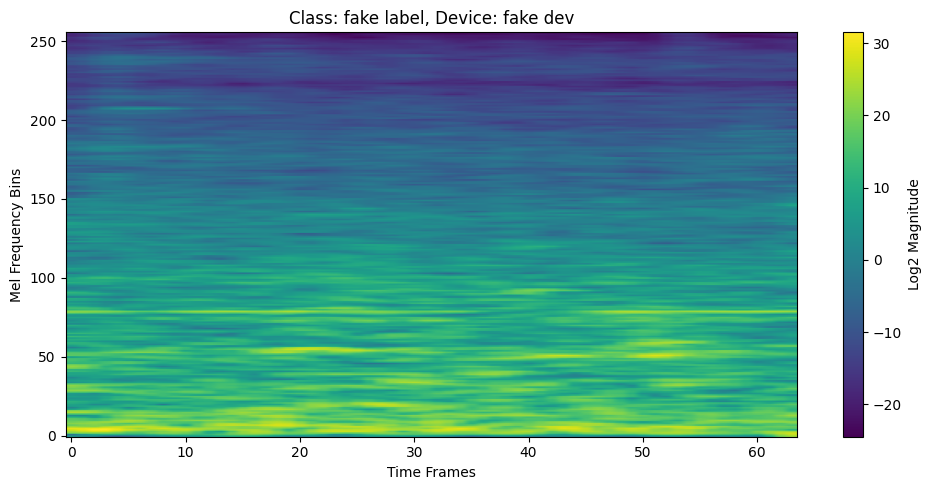

In [6]:
def precompute_and_save_mel_spectrograms(data_loader, dataset, meta_name):
    print(f"Precomputing and saving mel-spectrograms to {meta_name}.npz ...")
    # Inside your function...
    all_data = {
        'name':[],
        'mel':[],
        'device':[],
        'label': []
    }
    outdir = '/'.join(meta_name.split('/')[0:-1])
    os.makedirs(outdir, exist_ok=True)
   
    for batch_idx, (mel_spec, device, label) in enumerate(data_loader):
        for i in range(mel_spec.shape[0]):
            audio_file = dataset.filenames[batch_idx * data_loader.batch_size + i]
            filename = os.path.basename(audio_file).replace('.wav', '')
            all_data['name'].append(filename)
            all_data['mel'].append(mel_spec[i].squeeze().cpu().numpy())
            all_data['device'].append(device[i])
            all_data['label'].append(label[i])    
            
        print(f"Batch {batch_idx}/{len(data_loader)} finished")
        
    np.savez_compressed(
        meta_name,
        name=all_data['name'],
        mel=all_data['mel'],
        device=all_data['device'],
        label=all_data['label']
    )
    print("✅ Mel-spectrograms and metadata saved successfully.\n\n")


precompute_and_save_mel_spectrograms(train_loader, train_dataset, "/kaggle/working/dataset/train")
precompute_and_save_mel_spectrograms(test_loader, test_dataset, "/kaggle/working/dataset/test")

mel_file_path = "/kaggle/working/dataset/train.npz" # Path to the .npz file
data = np.load(mel_file_path) # Load the .npz file
mel_specs = data['mel']  # Loaded as a numpy array
print("Mel Spectrogram shape:", mel_specs.shape, end="\n\n") # Print shapes/types to verify

def plot_single_mel_spectrogram(mel_spec, label, dev):
    # Plot the mel-spectrogram
    plt.figure(figsize=(10, 5))
    plt.imshow(mel_spec, origin='lower', aspect='auto', cmap='viridis')
    plt.title(f"Class: {label}, Device: {dev}")
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Frequency Bins")
    plt.colorbar(label="Log2 Magnitude")
    plt.tight_layout()
    plt.show()

plot_single_mel_spectrogram(mel_specs[0], label="fake label", dev='fake dev')